# Hydrologische informatieproducten HDSR

Dit notebook bevat een workflow om geautomatiseerd een aantal hydrologische informatieproducten af te leiden uit modeluitvoer. 

* [1. Voorbereiding](#voorbereiding)
* [2. Brondata](#brondata)
   * [2.1 Meteorologische forcering](#forcering)
       * [2.1.1 KLimaatscenario's](#scenarios)
       * [2.1.2 Historische gegevens](#historie)
   * [2.2 Hydromedah](#hydromedah)
   * [2.3 LHM](#LHM)

<a id="voorbereiding"/>

# 1. Voorbereiding 

We hebben een aantal paden nodig hier moeten worden aangepast:

In [14]:
# De locatie waar hdsrshipy vanuit github is gedownload. Standaard is dit een niveau hoger dan dit notebook.
import os
package_path = os.path.abspath('../')

# De locatie waar de template-schematisatie van Hydromedah staat en waar ook de uitvoer wordt gegenereerd. 
# Ook historische mete-bestanden (uit WIWB) worden hier ook geplaastst. Let op: hier is relatief veel schijfruimte (~40 GB) voor nodig!
hydromedah_path = os.path.join(r'E:\Hydromedah')

# KNMI klimaatscenario's worden niet noodzakelijkerwijs op dezelfde locatie geplaatst. Dit is het pad waar ze worden gedownload.
scenario_path = r'E:\\scenarios\\'

# De locatie waar de informatieproducten worden geplaastst.
export_path = r'D:\4569.10\Results'

Laad een aantal externe benodigde bibliotheken en de klassen van het hdsrhipy-pakket.

In [12]:
import sys
import shutil
import ipywidgets
from pathlib import Path
get_ipython().run_line_magic('matplotlib', 'inline')
sys.path.append(package_path)  
from hdsrhipy import Meteorology
from hdsrhipy import Hydromedah
from hdsrhipy import Groundwater
from hdsrhipy import Maatgevend
from hdsrhipy.core.nauwkeurigheid import *
from hdsrhipy import Runoff

<a id='brondata'/>


# 2. Brondata 

<a id='forcering'/>

## 2.1 Meteorologische forcering 

<a id='scenarios'/>

### 2.1.1. Klimaatscenario's

Rasters voor de gewenste klimaatscenario's zijn te downloaden via het KNMI Data Platform (KDP; https://dataplatform.knmi.nl/). Voor kleine hoeveelheden data is een 'open-data key' beschikaar, maar voor het downloaden van een complete dataset (zoals 30 jaar aan dagelijkse data) is een dedicated 'key' nodig die is te krijgen via [dataservices@knmi.nl](mailto:dataservices@knmi.nl). Als in onderstaand commando geen key wordt meegeven ('key=None') wordt de open-data-key gebruikt.

Voor nu zijn de scenario's voor zichtjaar 2085 gedownload. De database die beschikbaar is via de KNMI API-bevat een fout; de referentieverdamping voor het scenarios GL klopt namelijk niet (bleek uit communicatie met KNMI). Voor nu zijn dus de overige drie scenario's gedownload. Als de fout is opgelost kan op onderstaande wijze (en een aparte key) het resterende scenario worden klaargezet.

In [ ]:
meteo = Meteorology()
# zet aan d.m.v. True
if True:    
    # er zit volgens KNMI nog een fout in het GL scenario, dus download deze zes scenario's
    datasets = ['RD85WL', 'EV85WL','RD85WH','EV85WH','RD85GH','EV85GH']
    for dat in datasets:
        if dat.startswith('RD'):
            var = 'precipitation'
        elif dat.startswith('EV'):
            var = 'evaporation'
        
        # het moet in stukjes, want de API ondersteunt max. 1000 files per keer. Dus we doen 1 jaar per bevraging.
        for y in range(2070,2100):        
            print('Downloading '+dat+'for '+str(y)+'...')
            start = 'INTER_OPER_R___'+dat+'__L3__'+str(y)+'0101T080000_'+str(y)+'0102T080000_0014.nc'
            meteo.download_from_KNMI(api_key=None, variable=var, dataset_name=dat, dataset_version='014', max_keys=366, start_after=start, download_path = Path(scenario_path,dat))

<a id='historie'/>


### 2.2.2 Historische data

Historische gegevens van neerslag(radar) en referentiegewasverdamping (Makkink) halen we uit WIWB. Hier is voor de gewenste periode geen doorlopend product beschikbaar, dus we downloaden Meteobase neerslag voor jaren t/m 2018 en IRC Final reanalysis daarna. Makkink is voor de gehele periode beschikbaar. Het IRC-grid vereist enkele extra bewerkingen, hier wordt het geresampled naar het oorspronkelijke Meteobase raster voor consistentie.

In [ ]:
# WIWB credentials:
credentials = (<HDSR_USERNAME>, <HDSR_PASSWORD>)

if False:
    # Meteobase neerslag t/m 2018
    meteo.download_from_WIWB(credentials=credentials, datasource='Meteobase.Precipitation', variable='precipitation', start='20100101000000', end='20190101000000', timestep='1D', download_path = Path(data_path))
    # Makkink verdamping
    meteo.download_from_WIWB(credentials=credentials, datasource='Meteobase.Evaporation.Makkink', variable='evaporation', start='20100101000000', end='20210101000000', timestep='1D', download_path = Path(data_path))
    # IRC vanaf 2019
    meteo.download_from_WIWB(credentials=credentials, datasource='Knmi.International.Radar.Composite.Final.Reanalysis', variable='precipitation', start='20190101000000', end='20210101000000', timestep='1D', download_path = Path(hydromedah_path))

<a id='hydromedah'/>

<a id='hydromedah'>

# 2.2 Hydromedah 

Als 

In [ ]:
name="Huidig250"

if False:
    # voor deze variabelen wordt Metaswap uitvoer weggeschreven
    msw_vars = ['ETact','S01','Ssd01', 'qinf']
    # maak een Hydromedah object aan. Precip_path en evap_path gaan uit van de 'root' van het pad en gaat ervanuit dat 'forcing/precipiation' of 'forcing/evaporation' worden toegevoegd.
    hydromedah = Hydromedah(data_path=hydromedah_path, name=name, precip_path=hydromedah_path, evap_path=hydromedah_path)

    # zet het model klaar met deze eigenschappen. Eextent is 'hardcoded' naar het HDSR-gebied. Als eerder runs zijn gedraaid op dzelfde resolutie kan eventueel 'add_surface_water' False zijn.
    hydromedah.setup_model(    start_date='2010-01-01', 
                               end_date='2020-12-31', 
                               resolution=250., 
                               add_surface_water=True, 
                               afw_shape = 'Afwateringseenheden', 
                               metaswap_vars = msw_vars)

    hydromedah.run_model(model_path = hydromedah_path)

    # haal de lateralen op uit het model...
    laterals = hydromedah.read_laterals(model_path=hydromedah_path)
    # en schrijf ze naar een csv.
    laterals.to_csv(os.path.join(export_path,'laterals_'+name+'.csv'),sep=",")
    
    # Modeluitvoer is groot en we hebben lang niet alles nodig.
    # Specifeer de variabelen en lagen die BEWAARD moeten blijven. Uit metaswap worden enkele grote CSV's en resterende binaire bestanden verwijderd.
    hydromedah.cleanup( modflow_vars = ['head','bdgflf'], modflow_layers = [1], metaswap_files = ['sw_hq_dtsw'])                 


# Watervraag- aanbod

Nog in te vullen.

# Maatgevende af- en aanvoer

Op basis van Hydromedah reeksen worden de maatgevende af- en aanvoer bepaald. De maatgevende afvoer is de dagelijks gemiddelde afvoer die 1 a 2 dagen per jaar wordt overschreden, de maatgevende aanvoer is de 10-daags gemiddelde aavvoer die ongeveer eens in de 10 jaar wordt overschreden.

In [4]:
mg = Maatgevend()
mg.get_laterals()
q_norm = mg.get_q_norm()

  0%|          | 0/1831 [00:00<?, ?it/s]

In [5]:
q_norm.head()

,CODE,geometry,CODENR,MQAF_M3S,MQAF_MMD,MQAAN_M3S,MQAAN_MMD
0,PG0003-1,"POLYGON ((138767.331 444719.836, 138724.919 44...",1,0.048570,13.273388,0.0,0.0
1,PG0004-1,"POLYGON ((146292.733 443230.648, 146289.877 44...",2,0.000000,0.000000,0.0,0.0
2,PG0006-1,"POLYGON ((145893.054 443602.715, 145886.623 44...",3,0.241768,83.714105,0.0,0.0
3,PG0007-1,"POLYGON ((139331.829 443471.812, 139330.109 44...",4,0.022006,9.203267,0.0,0.0
4,PG0008-1,"POLYGON ((139980.443 442641.467, 139973.696 44...",5,0.093363,16.818327,0.0,0.0


<AxesSubplot:>

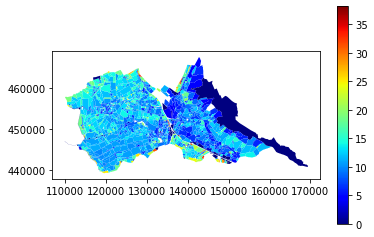

In [6]:
q_norm.loc[q_norm['MQAF_MMD'] > 40.] = np.nan
q_norm.plot('MQAF_MMD',cmap='jet', legend=True)

<AxesSubplot:>

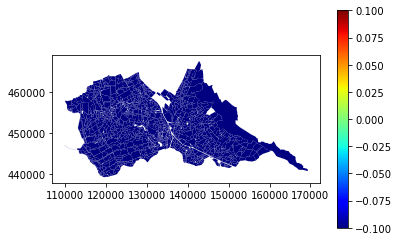

In [7]:
q_norm.plot('MQAAN_MMD',cmap='jet', legend=True)

In [8]:
q_norm.to_file(os.path.join(mg.export_path, 'maatgevend.shp'))        

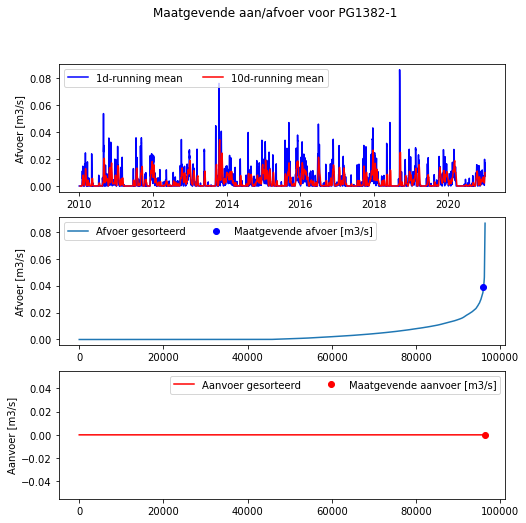

In [9]:
mg.plot_location(1828)

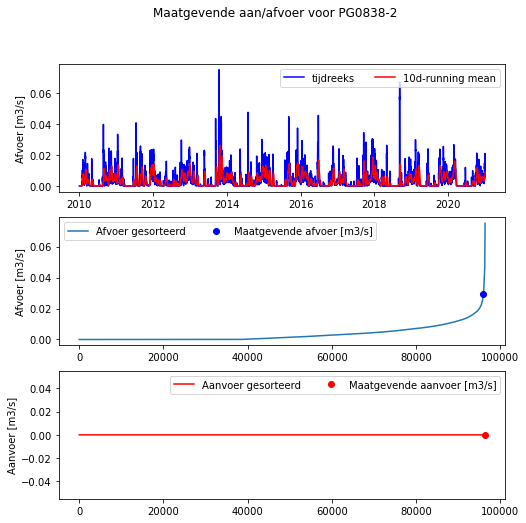

In [10]:
mg.plot_location(1328)

# GxG's

Op basis van de Modflow uitvoer bepalen stellen we de volgende kaarten samen:
 - GHG (gemiddelde van de drie hoogste grondwaterstanden in een hydrologisch jaar, gemiddeld over tenminste 8 jaar);
 - GLG (gemiddelde van de drie laagste grondwaterstanden in een hydrologisch jaar, gemiddeld over tenminste 8 jaar);
 - GVG (gemiddelde grondwaterstand over 14 maart, 28  maart en 14 april, gemiddeld over tenminste 8 jaar);
 - Kwel-wegzijging gemiddeld per seizoen (als seizoen hanteren we nu de maanden DJF, MAM, JJA, SON, voor winter, voorjaar, zomer en herfst, respectievelijk,
 - Rivierkwel (TODO). 
 
 We stellen eerst deze producten samen op de complete meetreeks, en voegen hierna de nauwkeurigheid daaraan toe.

In [ ]:
# initialiseer het object. De hierboven gedefinieerde locaties voor modeluitvoer e.d. worden meegegeven.
gw = Groundwater(model_path=hydromedah_path, export_path=export_path, name=name)

Haal de stijdghoogtes op uit Hydromedah.

In [ ]:
gw.get_heads()

Berekend de GxG's. Deze worden omgerekend naar diepte onder maaiveld via een maaiveldraster nodig. Standaard wordt het Hydromedah raster (25m) geaggregeerd naar de modelresolutie en gebruikt. 

In [ ]:
means = gw.get_gxg_raster()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

ax1 = plt.subplot(221)
plt.imshow(means['ghg'], cmap='jet', vmin=0,vmax=200)
ax1.set_title('GHG [m-mv]')
ax2 = plt.subplot(222)
plt.imshow(means['glg'], cmap='jet', vmin=0,vmax=200)
ax2.set_title('GLG [m-mv]')
ax3 = plt.subplot(223)
plt.imshow(means['gvg'], cmap='jet', vmin=0,vmax=200)
ax3.set_title('GVG [m-mv]')
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

Op basis hiervan wordt de grondwatertrappenkaart berekend. De indeling van grondwatertrappen is aangehouden (uit: Knotters e.a. (2018), Landsdekkende, actuele informatie over grondwatertrappen digitaal
beschikbaar, H20.)

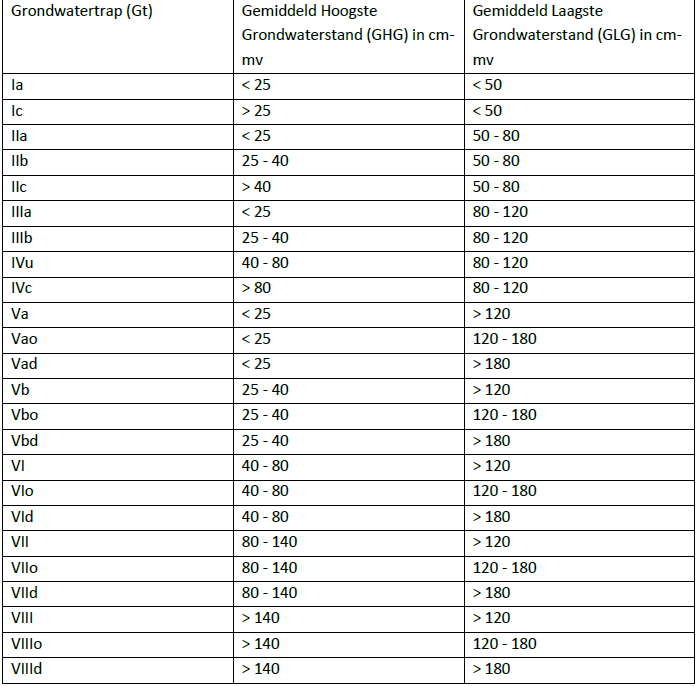

In [ ]:
means['gt'] = gw.get_gt_raster(gxg=means)

plt.imshow(means['gt'], cmap='jet', vmin=0, vmax=24)
plt.colorbar()
plt.show()

We berekenen de nauewkeurigheid uit een Monte Carlo analyse. Deze bestaat uit eental componetenten. Met de eeerste functie worden de basisdata 'n'x verstoord door er ruis uit een uniforme verdeling met een bepaalde bandbreedte bij op tellen.

In [ ]:
head_samples = sample_nauwkeurigheid(gw.heads, 0.05, n=5)  

Deze wordt gecombineerd met een bootstrap ('bootstrap_n' willekeurige periodes van 8 jaar). Deze levert een min/max versie van de GxG's. Voor elke realisatie wordt ook de GT bepaald. 

In [ ]:
(mins, maxs) = MonteCarlo('gxg', head_samples, bootstrap_n=5, n=10)

Zowel het 'best estimate' als de bandbreedte op basis van Monte Carlo wordt weggeschreven.

In [ ]:
items = ['GHG','GLG','GVG','GT']
for i in range(4):
    gw.export_raster(means[items[i].lower()], items[i]+'_best_'+name+'.tif')
    gw.export_raster(mins[i], items[i]+'_min_'+name+'.tif')
    gw.export_raster(maxs[i], items[i]+'_max_'+name+'.tif')
    

# Kwel-wegzijging

Bereken ook de kwel/wegzijging per seizoen. Bepaal de bandbreedtes en schrijf de rasters weg.

In [ ]:
gw.get_seepage()
means = gw.seepage_season_means()

sp_samples = sample_nauwkeurigheid(gw.seepage, 0.01, n=5)
(mins, maxs)  = MonteCarlo('seepage', sp_samples, bootstrap_n=5, n=10)

months = ['W','L','Z','N']
for i in range(4):
    gw.export_raster(means[i], 'SP_best_'+months[i]+'_'+name+'.tif')
    gw.export_raster(mins[i], 'SP_min_'+months[i]+'_'+name+'.tif')
    gw.export_raster(maxs[i], 'SP_max_'+months[i]+'_'+name+'.tif')    

Maak een figuur:

In [ ]:
ax1 = plt.subplot(221)
plt.imshow(means[0], cmap='jet', vmin=-1,vmax=1)
ax1.set_title('Winter [mm/d]')
ax2 = plt.subplot(222)
plt.imshow(means[1], cmap='jet', vmin=-1,vmax=1)
ax2.set_title('Voorjaar [mm/d]')
ax3 = plt.subplot(223)
plt.imshow(means[2], cmap='jet', vmin=-1,vmax=1)
ax3.set_title('Zomer [mm/d]')
ax4 = plt.subplot(224)
plt.imshow(means[3], cmap='jet', vmin=-1,vmax=1)
ax4.set_title('Najaar [mm/d]')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.show()

# Oppervlakkige afvoerkarakteristieken